In [1]:
# imports for RSA
from numpy import gcd, lcm, mean
from numpy.random import seed, randint
from sympy import factorint

# imports for Quantum
from qiskit import QuantumCircuit, QuantumRegister, Aer, execute, transpile
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import QFT
from qiskit_rigetti import QuilCircuit
from azure.quantum.qiskit import AzureQuantumProvider
from qiskit.quantum_info import Operator 

# imports extra
import json
import time
import matplotlib.pyplot as plt
import pandas
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
from fractions import Fraction

In [2]:
def initialize_qubits(qc, n, m):
    qc.h(range(n)) # apply hadamard gates
    qc.x(n+m-1) # set qubit to 1
    
def measure(qc, n):
    qc.measure(n, n)
    
def apply_iqft(qc, measurement_qubits):
    qc.append(QFT(len(measurement_qubits),
                  do_swaps=False).inverse(),
                  measurement_qubits)
    
def period_finder(n, m, a):
    
    # set up quantum circuit
    qc = QuantumCircuit(n+m, n)
    
    # initialize the qubits
    initialize_qubits(qc, n, m)
    qc.barrier()

    # apply modular exponentiation
    modular_exponentiation(qc, n, m, a)
    qc.barrier()

    # apply inverse QFT
    apply_iqft(qc, range(n))
    qc.barrier()

    # measure the n measurement qubits
    measure(qc, range(n))
    
    return qc

In [3]:
def primitive_roots(p):
    phi = p - 1
    factors = list(factorint(phi).keys())
    roots = []
    for g in range(2, p):
        if all(pow(g, phi // f, p) != 1 for f in factors):
            roots.append(g)
    return roots

# Example with p=97
p = 33
roots = primitive_roots(p)
#print(f"Primitive roots of {p} are {roots}")

In [4]:
# Precompute the quantum circuits for each value of `a`
lookup_table = {}
for a in [2, 6, 8, 13, 14, 19, 24, 26, 29, 31, 32, 33, 34, 37, 38, 41, 43, 44, 46, 47, 52, 53]:
    U = QuantumCircuit(6)
    if a in [2, 13, 24, 38, 49]:
        U.swap(0,1)
        U.swap(1,2)
        U.swap(2,3)
        U.swap(3,4)
        U.swap(4,5)
    elif a in [6, 19, 31, 43]:
        U.swap(1,3)
        U.swap(2,4)
        U.swap(3,5)
    elif a in [8, 32]:
        U.swap(2,4)
        U.swap(3,5)
        U.swap(1,3)
    elif a in [14, 47]:
        U.swap(1,4)
        U.swap(0,3)
    elif a in [26, 44]:
        U.swap(2,5)
        U.swap(1,4)
        U.swap(0,3)
    elif a in [29, 52]:
        U.swap(1,5)
        U.swap(0,4)
    elif a in [33, 46]:
        U.swap(0,2)
        U.swap(2,4)
        U.swap(1,3)
        U.swap(3,5)
    elif a == 41:
        U.swap(0,5)
        U.swap(1,4)
        U.swap(2,3)
    elif a == 37:
        for q in range(6):
            U.x(q)
    U = U.to_gate()
    U.name = f"U({a})"
    lookup_table[a] = U

def a_x_mod55(a, x):
    if a not in lookup_table:
        raise ValueError("'a' must be a primitive root modulo 55")
    U = lookup_table[a].copy()
    c_U = U.control()
    return c_U


In [5]:
#Quantum Circuit Modulus
def a_x_mod15(a, x):
    if a not in [2,7,8,11,13]:
        raise ValueError("'a' must be 2,7,8,11 or 13")
    U = QuantumCircuit(4)        
    for iteration in range(x):
        if a in [2,13]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [7,8]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a == 11:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = f"U({x})"
    c_U = U.control()
    return c_U

def a_x_mod21(a, x):
    if a not in [2,3,5,7,11,13,17,19]:
        raise ValueError("'a' must be one of 2, 3, 5, 7, 11, 13, 17, or 19")
    U = QuantumCircuit(5)        
    for iteration in range(x):
        if a in [2,19]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
            U.swap(3,4)
        if a in [3,17]:
            U.swap(3,4)
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a in [5,13]:
            U.swap(1,4)
            U.swap(0,3)
            U.swap(2,4)
            U.swap(1,3)
        if a in [7,11]:
            U.swap(2,4)
            U.swap(1,3)
            U.swap(0,2)
            U.swap(1,3)
    U = U.to_gate()
    U.name = f"U({x})"
    c_U = U.control()
    return c_U

def a_x_mod33(a, x):
    if a not in [2,7,8,11,13,17,19,23,29,31]:
        raise ValueError("'a' must be a primitive root modulo 33")
    U = QuantumCircuit(5)        
    for iteration in range(x):
        if a in [2,31]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
            U.swap(3,4)
        if a in [7,23]:
            U.swap(3,4)
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a == 19:
            U.swap(1,4)
            U.swap(0,3)
        if a in [11,17,29]:
            U.swap(2,4)
            U.swap(0,2)
        if a in [7,11,13,17,19,23,29,31]:
            for q in range(5):
                U.x(q)
    U = U.to_gate()
    U.name = f"U({x})"
    c_U = U.control()
    return c_U

def a_x_mod35(a, x):
    if a not in [2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 32]:
        raise ValueError("'a' must be a primitive root modulo 35")
    U = QuantumCircuit(5)        
    for iteration in range(x):
        if a in [2, 31, 32]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
            U.swap(3,4)
        if a in [7, 23]:
            U.swap(3,4)
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a == 19:
            U.swap(1,4)
            U.swap(0,3)
        if a in [11, 17, 29]:
            U.swap(2,4)
            U.swap(0,2)
        if a in [3, 5, 7, 11, 13, 17, 19, 23, 29, 31]:
            for q in range(5):
                U.x(q)
    U = U.to_gate()
    U.name = f"U({x})"
    c_U = U.control()
    return c_U

def a_x_mod39(a, x):
    if a not in [2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37]:
        raise ValueError("'a' must be a primitive root modulo 39")
    U = QuantumCircuit(5)        
    for iteration in range(x):
        if a in [2, 37]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
            U.swap(3,4)
        if a in [7, 23]:
            U.swap(3,4)
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a == 19:
            U.swap(1,4)
            U.swap(0,3)
        if a in [11, 17, 29]:
            U.swap(2,4)
            U.swap(0,2)
        if a in [3, 5, 11, 13, 17, 19, 29, 31]:
            for q in range(5):
                U.x(q)
    U = U.to_gate()
    U.name = f"U({x})"
    c_U = U.control()
    return c_U

def a_x_mod51(a, x):
    if a not in [7, 19, 31, 37, 43, 47]:
        raise ValueError("'a' must be a primitive root modulo 51")
    U = QuantumCircuit(6)        
    for iteration in range(x):
        if a == 7:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
            U.swap(3,4)
            U.swap(4,5)
        if a == 19:
            U.swap(1,4)
            U.swap(0,3)
        if a == 31:
            U.swap(2,5)
            U.swap(1,4)
            U.swap(0,3)
        if a == 37:
            U.swap(3,5)
            U.swap(2,4)
            U.swap(1,3)
            U.swap(0,2)
        if a == 43:
            U.swap(1,5)
            U.swap(0,4)
            U.swap(2,3)
        if a == 47:
            U.swap(0,5)
            U.swap(1,4)
            U.swap(2,3)
        for q in range(6):
            U.x(q)
    U = U.to_gate()
    U.name = f"U({x})"
    c_U = U.control()
    return c_U

# Precompute the quantum circuits for each value of `a`
lookup_table = {}
for a in [2, 6, 8, 13, 14, 19, 24, 26, 29, 31, 32, 33, 34, 37, 38, 41, 43, 44, 46, 47, 52, 53]:
    U = QuantumCircuit(6)
    if a in [2, 13, 24, 38, 49]:
        U.swap(0,1)
        U.swap(1,2)
        U.swap(2,3)
        U.swap(3,4)
        U.swap(4,5)
    elif a in [6, 19, 31, 43]:
        U.swap(1,3)
        U.swap(2,4)
        U.swap(3,5)
    elif a in [8, 32]:
        U.swap(2,4)
        U.swap(3,5)
        U.swap(1,3)
    elif a in [14, 47]:
        U.swap(1,4)
        U.swap(0,3)
    elif a in [26, 44]:
        U.swap(2,5)
        U.swap(1,4)
        U.swap(0,3)
    elif a in [29, 52]:
        U.swap(1,5)
        U.swap(0,4)
    elif a in [33, 46]:
        U.swap(0,2)
        U.swap(2,4)
        U.swap(1,3)
        U.swap(3,5)
    elif a == 41:
        U.swap(0,5)
        U.swap(1,4)
        U.swap(2,3)
    elif a == 37:
        for q in range(6):
            U.x(q)
    U = U.to_gate()
    U.name = f"U({a})"
    lookup_table[a] = U

def a_x_mod55(a, x):
    if a not in lookup_table:
        raise ValueError("'a' must be a primitive root modulo 55")
    U = lookup_table[a].copy()
    c_U = U.control()
    return c_U


def a_x_mod57(a, x):
    if a not in [3, 5, 6, 17, 19, 20, 21, 22, 23, 24, 30, 33, 34, 35, 36, 39, 41, 45, 46, 48]:
        raise ValueError("'a' must be a primitive root modulo 57")
    U = QuantumCircuit(6) 
    for i in range(x):
        if a in [3, 20, 21, 36, 45]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
            U.swap(3,4)
            U.swap(4,5)
        if a in [5, 17, 23, 33, 39]:
            U.swap(1,3)
            U.swap(2,4)
            U.swap(3,5)
        if a in [6, 48]:
            U.swap(2,4)
            U.swap(3,5)
            U.swap(1,3)
        if a in [19, 46]:
            U.swap(1,4)
            U.swap(0,3)
        if a in [24, 41]:
            U.swap(2,5)
            U.swap(1,4)
            U.swap(0,3)
        if a in [30, 48]:
            U.swap(1,5)
            U.swap(0,4)
        if a in [34, 46]:
            U.swap(0,2)
            U.swap(2,4)
            U.swap(1,3)
            U.swap(3,5)
        if a == 22:
            U.swap(0,5)
            U.swap(1,4)
            U.swap(2,3)
        if a == 39:
            for q in range(6):
                U.x(q)
    U = U.to_gate()
    U.name = f"U({x})"
    c_U = U.control()
    return c_U

def a_x_mod65(a, x):
    if a not in [2, 3, 4, 5, 7, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 57, 58, 59, 60, 61, 62, 63]:
        raise ValueError("'a' must be a primitive root modulo 65")
    U = QuantumCircuit(7) 
    for i in range(x):
        if a in [2, 3, 8, 32]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
            U.swap(3,4)
            U.swap(4,5)
            U.swap(5,6)
        if a in [4, 16, 23, 36, 39, 46, 54]:
            U.swap(1,3)
            U.swap(2,4)
            U.swap(4,6)
        if a in [5, 20, 29, 31, 45, 56]:
            U.swap(1,4)
            U.swap(0,3)
            U.swap(2,5)
        if a in [7, 28, 30, 44, 59]:
            U.swap(1,5)
            U.swap(2,6)
            U.swap(0,4)
        if a in [9, 13, 18, 24, 42, 48, 53, 58]:
            U.swap(2,5)
            U.swap(3,6)
        if a in [10, 19, 22, 34, 47, 52, 61, 62]:
            U.swap(0,5)
            U.swap(1,6)
        if a in [11, 21, 35, 40, 49, 50, 55, 64]:
            U.swap(0,6)
            U.swap(2,5)
            U.swap(3,4)
        if a in [12, 17, 37, 43, 51, 57, 60, 63]:
            U.swap(0,2)
            U.swap(4,6)
            U.swap(1,3)
            U.swap(2,4)
            U.swap(3,5)
        if a in [14, 41]:
            for q in range(7):
                U.x(q)
        if a in [15, 25]:
            for q in range(7):
                U.swap(q, 6-q)
    #U = Operator(U)
    U = U.to_gate()
    U.name = f"U({x})"
    c_U = U.control()
    return c_U

def a_x_mod69(a, x):
    if a not in [2, 3, 5, 6, 7, 10, 11, 14, 15, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 33, 34, 35, 37, 38, 39, 41, 43, 44, 45, 46, 47, 51, 53, 54, 56, 57, 58, 59, 60, 62, 63, 64, 65, 66, 67, 68]:
        raise ValueError("'a' must be a primitive root modulo 69")
    U = QuantumCircuit(7)
    for i in range(x):
        if a in [2, 22, 23, 41, 43, 44, 48, 51, 52, 58, 59, 61, 64, 68]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
            U.swap(3,4)
            U.swap(4,5)
            U.swap(5,6)
        if a in [3, 11, 24, 27, 28, 29, 30, 33, 34, 35, 37, 39, 42, 45, 46, 47, 56, 57, 60, 62, 63, 65, 66, 67]:
            U.swap(0,3)
            U.swap(1,4)
            U.swap(2,5)
            U.swap(3,6)
        if a in [5, 10, 15, 17, 20, 21, 26, 31, 38, 40, 49, 53, 54, 55]:
            U.swap(1,5)
            U.swap(2,4)
        if a in [6, 14, 19, 36, 50]:
            U.swap(1,3)
            U.swap(2,4)
            U.swap(3,5)
        if a in [7, 30, 32, 52]:
            U.swap(0,2)
            U.swap(2,4)
            U.swap(4,6)
        if a in [17, 28, 31, 47, 53]:
            U.swap(1,6)
            U.swap(0,5)
        if a in [21, 27, 46, 57]:
            U.swap(0,4)
            U.swap(2,6)
        if a in [24, 42, 60]:
            U.swap(0,3)
            U.swap(3,6)
        if a in [38, 49, 66]:
            U.swap(1,4)
            U.swap(4,6)
        if a == 11:
            for q in range(7):
                U.x(q)
        if a == 52:
            U.swap(0,6)
            U.swap(1,5)
            U.swap(2,4)
    U = U.to_gate()
    U.name = f"U({x})"
    c_U = U.control()
    return c_U

def a_x_mod77(a, x):
    if a not in [3, 5, 6, 7, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 29, 30, 31, 32, 33, 34, 35, 36, 38, 39, 40, 41, 43, 44, 45, 46, 47, 48, 49, 50, 51, 53, 54, 55, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 68, 69, 70, 71]:
        raise ValueError("'a' must be a primitive root modulo 77")
    U = QuantumCircuit(8)
    for i in range(x):
        if a in [3, 7, 20, 23, 24, 27, 29, 30, 31, 34, 35, 36, 38, 39, 44, 46, 47, 48, 49, 50, 53, 54, 55, 57, 58, 59, 61, 62, 63, 65, 66, 68, 69, 70, 71]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
            U.swap(3,4)
            U.swap(4,5)
            U.swap(5,6)
            U.swap(6,7)
        if a in [5, 13, 18, 21, 26, 32, 33, 40, 41, 45, 51, 56, 60]:
            U.swap(1,4)
            U.swap(2,3)
            U.swap(5,7)
        if a in [6, 17, 19, 28, 37, 42, 43, 52, 67]:
            U.swap(1,3)
            U.swap(2,6)
            U.swap(4,5)
        if a in [10, 12, 15, 16, 22, 25, 58]:
            U.swap(1,5)
            U.swap(2,4)
            U.swap(3,7)
        if a in [11, 48]:
            for q in range(8):
                U.x(q)
        if a == 50:
            U.swap(0,7)
            U.swap(1,6)
            U.swap(2,5)
            U.swap(3,4)
        if a == 64:
            U.swap(0,4)
            U.swap(1,5)
            U.swap(2,6)
            U.swap(3,7)
    U = U.to_gate()
    U.name = f"U({x})"
    c_U = U.control()
    return c_U

def a_x_mod85(a, x):
    if a not in [3, 11, 13, 17, 22, 27, 28, 33, 34, 36, 39, 44, 46, 47, 48, 52, 53, 54, 57, 58, 59, 61, 62, 63, 66, 67, 68, 69, 71, 72, 73, 76, 77, 78, 79, 82, 83]:
        raise ValueError("'a' must be a primitive root modulo 85")
    U = QuantumCircuit(8)
    for i in range(x):
        if a in [3, 11, 13, 17, 22, 27, 34, 36, 39, 44, 46, 47, 48, 53, 54, 57, 59, 62, 63, 66, 67, 68, 69, 71, 72, 73, 76, 77, 78, 79, 83]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
            U.swap(3,4)
            U.swap(4,5)
            U.swap(5,6)
            U.swap(6,7)
        if a in [28, 33, 52, 58, 61]:
            U.swap(1,4)
            U.swap(2,3)
            U.swap(5,7)
        if a in [44, 77]:
            U.swap(1,3)
            U.swap(2,6)
            U.swap(4,5)
        if a in [46, 48, 78, 82]:
            U.swap(1,5)
            U.swap(2,4)
            U.swap(3,7)
        if a == 27:
            for q in range(8):
                U.x(q)
        if a == 73:
            U.swap(0,7)
            U.swap(1,6)
            U.swap(2,5)
            U.swap(3,4)
        if a == 59:
            U.swap(0,4)
            U.swap(1,5)
            U.swap(2,6)
            U.swap(3,7)
    U = U.to_gate()
    U.name = f"U({x})"
    c_U = U.control()
    return c_U

def a_x_mod91(a, x):
    if a not in [8, 19, 29, 31, 37, 41, 43, 46, 47, 51, 53, 58, 59, 61, 62, 64, 65, 67, 68, 69, 71, 73, 74, 79, 82, 83, 84, 85]:
        raise ValueError("'a' must be a primitive root modulo 91")
    U = QuantumCircuit(9)
    for i in range(x):
        if a in [8, 19, 31, 43, 46, 47, 51, 53, 62, 64, 65, 67, 68, 69, 71, 74, 79, 82, 83, 85]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
            U.swap(3,4)
            U.swap(4,5)
            U.swap(5,6)
            U.swap(6,7)
            U.swap(7,8)
        if a in [37, 41, 59, 61]:
            U.swap(1,3)
            U.swap(2,6)
            U.swap(4,5)
            U.swap(7,8)
        if a == 29:
            U.swap(0,8)
            U.swap(1,7)
            U.swap(2,6)
            U.swap(3,5)
        if a == 53:
            U.swap(0,7)
            U.swap(1,6)
            U.swap(2,5)
            U.swap(3,4)
            U.swap(4,8)
        if a == 74:
            U.swap(0,8)
            U.swap(1,7)
            U.swap(2,6)
            U.swap(3,5)
            U.swap(4,7)
            U.swap(5,6)
            U.swap(6,8)
        if a == 83:
            for q in range(9):
                U.x(q)
        if a == 59:
            U.swap(0,4)
            U.swap(1,5)
            U.swap(2,6)
            U.swap(3,7)
            U.swap(4,8)
        if a == 31:
            U.swap(0,6)
            U.swap(1,7)
            U.swap(2,8)
            U.swap(3,5)
            U.swap(4,6)
        if a == 71:
            U.swap(0,8)
            U.swap(1,7)
            U.swap(2,6)
            U.swap(3,5)
            U.swap(4,8)
            U.swap(5,7)
            U.swap(6,8)
        if a == 68:
            U.swap(0,8)
            U.swap(1,7)
            U.swap(2,6)
            U.swap(3,5)
            U.swap(4,8)
            U.swap(5,7)
            U.swap(6,8)
            U.swap(7,8)
    U = U.to_gate()
    U.name = f"U({x})"
    c_U = U.control()
    return c_U

def a_x_mod93(a, x):
    if a not in [5, 7, 11, 13, 14, 15, 17, 19, 20, 22, 23, 25, 26, 28, 29, 31, 32, 34, 35, 37, 38, 41, 43, 44, 46, 47, 49, 50, 52, 53, 56, 58, 59, 61, 62, 64, 65, 67, 68, 70, 71, 73, 74, 76, 77, 79, 80, 82, 83, 85, 86, 88, 89, 91, 92]:
        raise ValueError("'a' must be a primitive root modulo 93")
    U = QuantumCircuit(8)
    for i in range(x):
        if a in [5, 11, 19, 20, 22, 23, 25, 26, 28, 29, 35, 37, 43, 44, 46, 47, 49, 50, 52, 56, 58, 59, 61, 62, 64, 65, 67, 68, 70, 71, 77, 79, 80, 82, 83, 85, 86, 88, 89]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
            U.swap(3,4)
            U.swap(4,5)
            U.swap(5,6)
            U.swap(6,7)
        if a == 13:
            U.swap(0,3)
            U.swap(1,6)
            U.swap(2,5)
            U.swap(4,7)
        if a == 14:
            U.swap(0,2)
            U.swap(1,3)
            U.swap(4,6)
            U.swap(5,7)
        if a == 15:
            U.swap(0,4)
            U.swap(1,5)
            U.swap(2,6)
            U.swap(3,7)
        if a == 17:
            U.swap(0,5)
            U.swap(1,4)
            U.swap(2,7)
            U.swap(3,6)
        if a == 32:
            U.swap(1,3)
            U.swap(2,5)
            U.swap(4,6)
        if a == 38:
            U.swap(0,2)
            U.swap(1,3)
            U.swap(4,7)
            U.swap(5,6)
        if a == 41:
            U.swap(0,6)
            U.swap(1,5)
            U.swap(2,4)
            U.swap(3,7)
        if a == 52:
            U.swap(1,2)
            U.swap(3,6)
            U.swap(4,5)
        if a == 53:
            U.swap(0,3)
            U.swap(1,4)
            U.swap(2,5)
            U.swap(6,7)        
        if a == 73:
            U.swap(0,7)
            U.swap(1,6)
            U.swap(2,5)
            U.swap(3,4)
        if a == 59:
            U.swap(0,4)
            U.swap(1,5)
            U.swap(2,6)
            U.swap(3,7)
        if a == 74:
            U.swap(0,6)
            U.swap(1,3)
            U.swap(2,5)
            U.swap(4,7)
        if a == 76:
            U.swap(0,5)
            U.swap(1,6)
            U.swap(2,3)
            U.swap(4,7)
        if a == 77:
            U.swap(1,3)
            U.swap(2,6)
            U.swap(4,5)
        if a == 79:
            U.swap(0,6)
            U.swap(1,5)
            U.swap(2,4)
            U.swap(3,7)
        if a == 82:
            U.swap(0,4)
            U.swap(1,3)
            U.swap(2,5)
            U.swap(6,7)
        if a == 83:
            U.swap(0,3)
            U.swap(1,4)
            U.swap(2,5)
            U.swap(6,7)
        U = U.to_gate()
        U.name = f"U({x})"
        c_U = U.control()
        return c_U



def modular_exponentiation(qc, n, m, a):
    for x in range(n):
        exponent = 2**x
        
        if N == 15:
            qc.append(a_x_mod15(a, exponent), [x] + list(range(n, n+m)))
        elif N == 21:
            qc.append(a_x_mod21(a, exponent), [x] + list(range(n, n+m)))
        elif N == 33:
            qc.append(a_x_mod33(a, exponent), [x] + list(range(n, n+m)))
        elif N == 35:
            qc.append(a_x_mod35(a, exponent), [x] + list(range(n, n+m)))
        elif N == 39:
            qc.append(a_x_mod39(a, exponent), [x] + list(range(n, n+m)))
        elif N == 51:
            qc.append(a_x_mod51(a, exponent), [x] + list(range(n, n+m)))
        elif N == 55:
            qc.append(a_x_mod55(a, exponent), [x] + list(range(n, n+m)))
        elif N == 57:
            qc.append(a_x_mod57(a, exponent), [x] + list(range(n, n+m)))
        elif N == 65:
            qc.append(a_x_mod65(a, exponent), [x] + list(range(n, n+m)))
        elif N == 69:
            qc.append(a_x_mod69(a, exponent), [x] + list(range(n, n+m)))
        elif N == 77:
            qc.append(a_x_mod77(a, exponent), [x] + list(range(n, n+m)))
        elif N == 85:
            qc.append(a_x_mod85(a, exponent), [x] + list(range(n, n+m)))
        elif N == 91:
            qc.append(a_x_mod91(a, exponent), [x] + list(range(n, n+m)))
        elif N == 93:
            qc.append(a_x_mod93(a, exponent), [x] + list(range(n, n+m)))
        elif N == 95:
            qc.append(a_x_mod95(a, exponent), [x] + list(range(n, n+m)))
        elif N == 111:
            qc.append(a_x_mod111(a, exponent), [x] + list(range(n, n+m)))
        elif N == 115:
            qc.append(a_x_mod115(a, exponent), [x] + list(range(n, n+m)))

In [6]:
QC = []
for N,a in ((15,7),(21,2),(33,7),(35,7),(39,2),(51,7),(55,13),(57,5),(65,13),(69,7),(77,5),(85,3)):
    if N == 15:
        QC.append((period_finder(4, 4, a), N, a))
    elif N>=91:
        QC.append((period_finder(9, 9, a), N, a))
    elif N>=77:
        QC.append((period_finder(8, 8, a), N, a))
    elif N>=65:
        QC.append((period_finder(7, 7, a), N, a))
    elif N>=51:
        QC.append((period_finder(6, 6, a), N, a))
    else:
        QC.append((period_finder(5, 5, a), N, a))

#Other pairs
#,(91,19),(93,5),(95,2),(111,2),(115,2)

In [7]:
#Quantum - Azure ID
provider = AzureQuantumProvider(
  resource_id="/subscriptions/8023b696-b967-4ced-93ef-92c0044503f4/resourceGroups/AzureQuantum/providers/Microsoft.Quantum/Workspaces/QUANTUM-LABINOV",
  location="West Europe"
)

In [8]:
#Quantum - ionQ Cost Estimate
#Available Backends: ionq.qpu, ionq.qpu.aria-1

qpu_backend = provider.get_backend("ionq.qpu.aria-1")
costs = []
for i in range(0,len(QC),1):
    circuit = transpile(QC[i][0], qpu_backend)
    cost = qpu_backend.estimate_cost(circuit, shots=100)
    costs.append(cost.estimated_total)

    print(f"Estimated cost: {cost.estimated_total} {cost.currency_code}")
print(f"Total cost: {sum(costs)} {cost.currency_code}")

WARNING - EnvironmentCredential.get_token failed: EnvironmentCredential authentication unavailable. Environment variables are not fully configured.
Visit https://aka.ms/azsdk/python/identity/environmentcredential/troubleshoot to troubleshoot.this issue.
WARNING - ImdsCredential.get_token failed: ManagedIdentityCredential authentication unavailable. The requested identity has not been assigned to this resource.
WARNING - ManagedIdentityCredential.get_token failed: ManagedIdentityCredential authentication unavailable. The requested identity has not been assigned to this resource.
WARNING - VisualStudioCodeCredential.get_token failed: Failed to get Azure user details from Visual Studio Code.
WARNING - VSCodeCredential.get_token failed: Failed to get Azure user details from Visual Studio Code.
WARNING - AzureCliCredential.get_token failed: Please run 'az login' to set up an account
WARNING - AzurePowerShellCredential.get_token failed: Az.Account module >= 2.2.0 is not installed


Estimated cost: 6.66645 USD
Estimated cost: 1.22255 USD
Estimated cost: 16.41255 USD
Estimated cost: 16.41255 USD
Estimated cost: 1.22255 USD
Estimated cost: 38.80065 USD
Estimated cost: 1.7566499999999998 USD
Estimated cost: 1.7566499999999998 USD
Estimated cost: 2.38875 USD
Estimated cost: 2.38875 USD
Estimated cost: 3.11885 USD
Estimated cost: 3.11885 USD
Total cost: 95.26579999999998 USD


Circuit for N=15 and a=7:

Figure(1207.22x785.944)


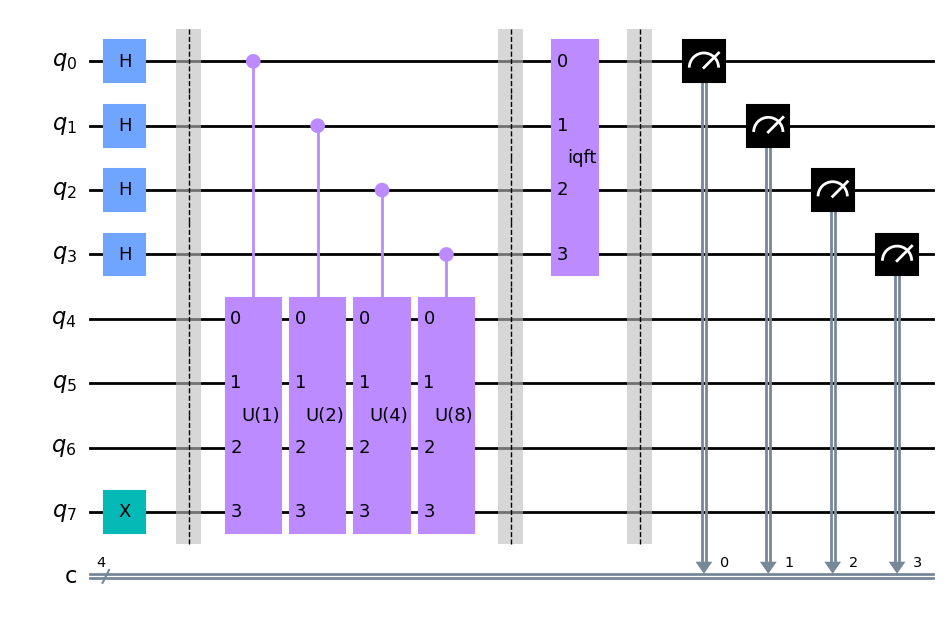

In [9]:
#Circuit Diagram before transpile
print(f"Circuit for N={QC[0][1]} and a={QC[0][2]}:\n")
print(QC[0][0].draw(output='mpl'))

Circuit for N=15 and a=7: 




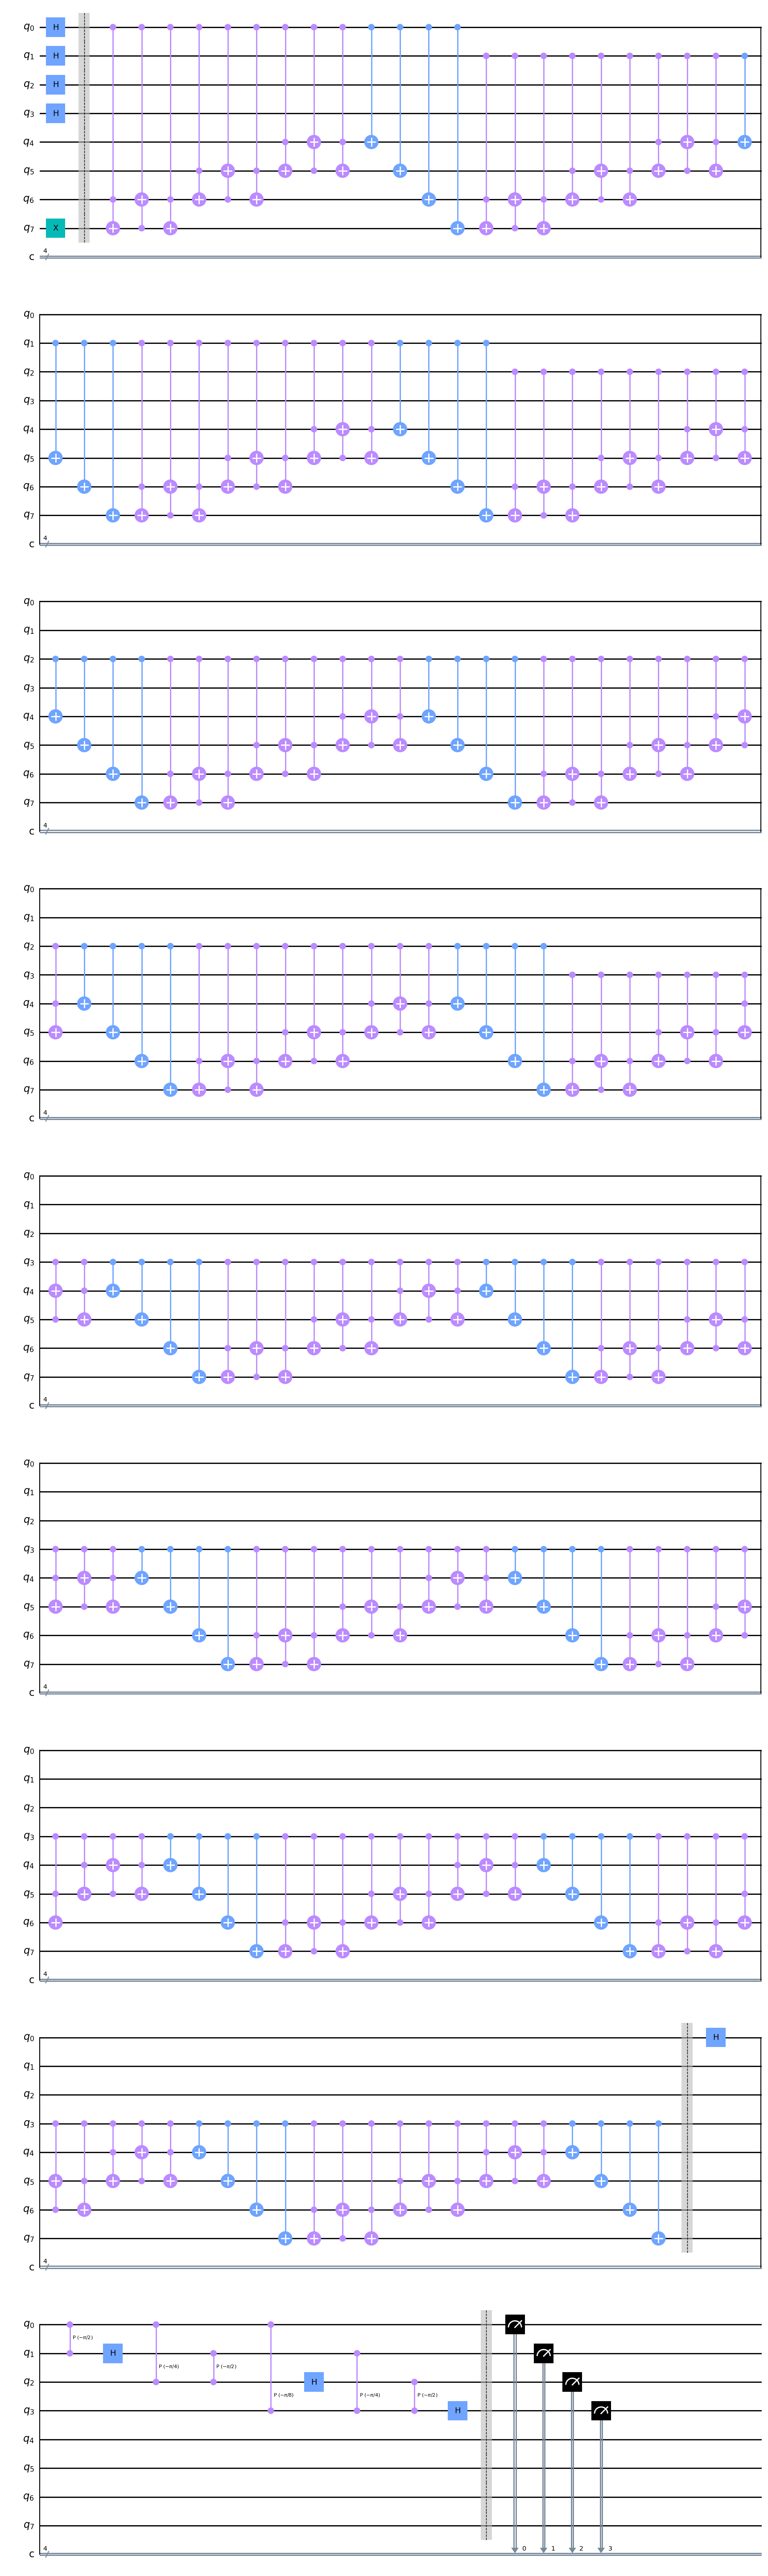

In [9]:
#Transformed Circuit
#Backends: ionq.qpu, ionq.qpu.aria-1, rigetti.qpu.aspen-m-2, rigetti.sim.qvm
qpu_backend = provider.get_backend("ionq.qpu")
circuit = transpile(QC[0][0], qpu_backend)
print(f"Circuit for N={QC[0][1]} and a={QC[0][2]}: \n")
circuit.draw(output='mpl')
print("")

In [28]:
#Job Running on a Quantum Computer
#Backends Simulators: ionq.simulator, rigetti.sim.qvm
#Backends Hardware: ionq.qpu, ionq.qpu.aria-1, rigetti.qpu.aspen-m-2, rigetti.qpu.aspen-m-3
qpu_backend = provider.get_backend("ionq.simulator") 
jobs = []

#Choose to run between QC or [QC[0 or 1...]]
for qc,N,a in QC:
    print(f"Running for circuit with N={N} and a={a}")
    qc = transpile(qc, qpu_backend)

    job = qpu_backend.run(qc,shots=100)
    jobs.append(job.job_id())
    print(f"Job ID= {job.job_id()}")
    print(f"Job Successfully Sent for N={N} and a={a}\n")

Running for circuit with N=15 and a=7
Job ID= 66f8dd84-e304-11ed-a9bb-000d3a2eb574
Job Successfully Sent for N=15 and a=7

Running for circuit with N=21 and a=2
Job ID= 6782078d-e304-11ed-8508-000d3a2eb574
Job Successfully Sent for N=21 and a=2

Running for circuit with N=33 and a=7
Job ID= 67b2c288-e304-11ed-b659-000d3a2eb574
Job Successfully Sent for N=33 and a=7

Running for circuit with N=35 and a=7
Job ID= 68f31020-e304-11ed-8090-000d3a2eb574
Job Successfully Sent for N=35 and a=7

Running for circuit with N=39 and a=2
Job ID= 6a39d134-e304-11ed-924b-000d3a2eb574
Job Successfully Sent for N=39 and a=2

Running for circuit with N=51 and a=7
Job ID= 6b96c6c8-e304-11ed-9ac7-000d3a2eb574
Job Successfully Sent for N=51 and a=7

Running for circuit with N=55 and a=13
Job ID= 6d67000f-e304-11ed-98fc-000d3a2eb574
Job Successfully Sent for N=55 and a=13

Running for circuit with N=57 and a=5
Job ID= 6daa232f-e304-11ed-a441-000d3a2eb574
Job Successfully Sent for N=57 and a=5

Running for ci

Job List:
 ['fe92faf3-e301-11ed-b85e-000d3a2eb574', 'feefe7f4-e301-11ed-a6ed-000d3a2eb574', 'ffb228f4-e301-11ed-9a55-000d3a2eb574', 'ffdfc888-e301-11ed-b48a-000d3a2eb574', '001b0ba2-e302-11ed-9097-000d3a2eb574', '008f1079-e302-11ed-8c7a-000d3a2eb574', '020cc1ee-e302-11ed-ba25-000d3a2eb574', '0243d4c8-e302-11ed-97c3-000d3a2eb574', '02836ffb-e302-11ed-83d7-000d3a2eb574', '02c2ea1a-e302-11ed-aaee-000d3a2eb574', '03494fbd-e302-11ed-986f-000d3a2eb574', '04027a2f-e302-11ed-8ae6-000d3a2eb574']

Job Result for circuit index= 0:
 Result(backend_name='ionq.simulator', backend_version='1', qobj_id='circuit-132', job_id='fe92faf3-e301-11ed-b85e-000d3a2eb574', success=True, results=[ExperimentResult(shots=10, success=True, meas_level=MeasLevel.CLASSIFIED, data=ExperimentResultData(counts={'0000': 5, '0010': 1, '1001': 1, '1010': 1, '1011': 1, '1111': 1}, probabilities=defaultdict(<class 'int'>, {'0000': 0.25, '0001': 0.205266736, '0010': 0.106694172, '0011': 0.025311164, '0101': 0.011300488, '0110'

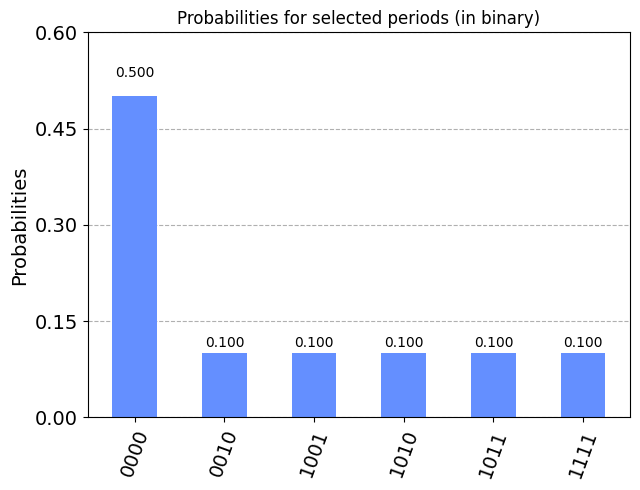

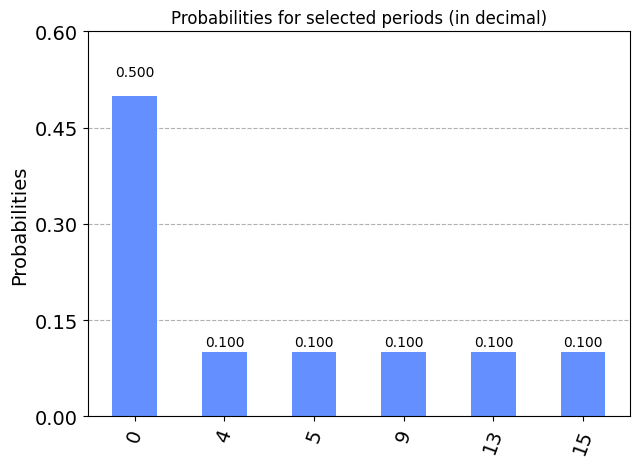

In [13]:
#Job Testing for one circuit
print(f"Job List:\n {jobs}\n")
c_index = 0
job_t = qpu_backend.retrieve_job(jobs[c_index])
print(f"Job Result for circuit index= {c_index}:\n {job_t.result()} \n")
print(f"Shot Count for each period (in binary) = {job_t.result().get_counts()} \n")

counts = job_t.result().get_counts()
cd = {}
for key in counts:
    k = int(key[::-1], 2)
    cd[k] = counts[key] 
    
#Barplot used to understand histogram results
#plt.bar(cd.keys(),cd.values(),width=0.5)
print(job.result().to_dict().get("probabilities"))
#print(job.result().to_dict())
#print("")

plot_histogram(counts, title='Probabilities for selected periods (in binary)')
plot_histogram(cd, title='Probabilities for selected periods (in decimal)')
print("")

        Register Output         Phase Fraction  Guess for r
0  0000(bin) =   0(dec)   0/16 = 0.00      0/1            1
1  0010(bin) =   4(dec)   4/16 = 0.25      1/4            4
2  1001(bin) =   9(dec)   9/16 = 0.56      5/9            9
3  1010(bin) =   5(dec)   5/16 = 0.31     4/13           13
4  1011(bin) =  13(dec)  13/16 = 0.81     9/11           11
5  1111(bin) =  15(dec)  15/16 = 0.94    14/15           15




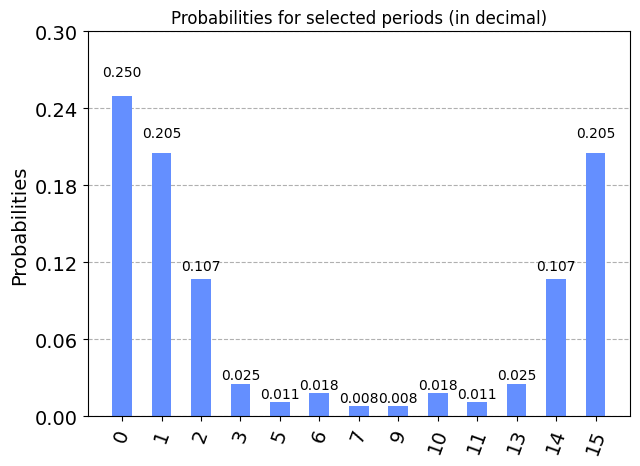

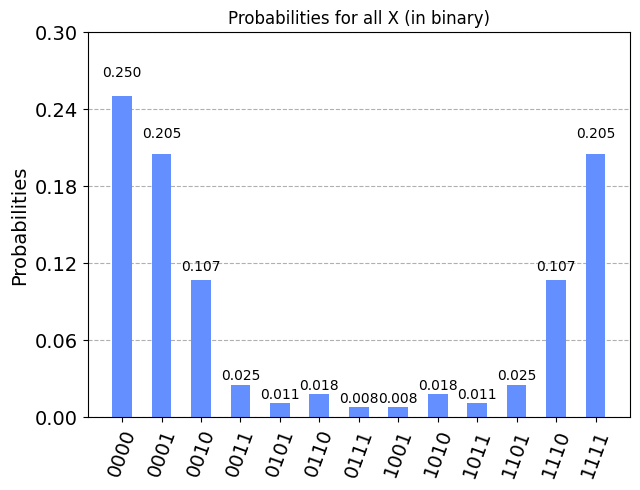

In [14]:
#Calculations - Counts, Phases, Periods 
#Phases
qubit = 4
rows = []
for output in counts:
    decimal = int(output[::-1], 2)  # Convert (base 2) string to decimal
    phase = decimal/(2**(qubit))  # Find corresponding eigenvalue
    frac = Fraction(phase).limit_denominator(15)
    # Add these values to the rows in our table:
    rows.append([f"{output}(bin) = {decimal:>3}(dec)",
                 f"{decimal}/{2**(qubit)} = {phase:.2f}",
                 f"{frac.numerator}/{frac.denominator}",
                 frac.denominator])

# Print the rows in a table
headers=["Register Output", "Phase","Fraction", "Guess for r"]
df = pandas.DataFrame(rows, columns=headers)
print(df)
print("")

#Probabilities
Probs = job_t.result().to_dict().get("results")[0].get("data").get("probabilities")
pd = {}
for key in Probs:
    k = int(key, 2)
    pd[k] = Probs[key]   
plot_histogram(pd, title='Probabilities for selected periods (in decimal)')

plot_histogram(Probs, title='Probabilities for all X (in binary)')
print("")

In [10]:
#Factor Finding Routine
timings = []
plots = []
#jobs = ["f38416e5-d7a9-11ed-8380-000d3a2eb574"]
#job_timings = [1,2,23,23,23,23,23,2,1,21,23,32]
#job.result().time_taken


#Retrieve job results
for j in range(0,len(jobs),1):
    
    tic = time.perf_counter()
    
    _,N,a = QC[j]
    job = qpu_backend.retrieve_job(jobs[j])
    counts = job.result().get_counts()
    
    #convert and add binary periods to list
    counts_dec = sorted([int(measured_value[::-1], 2) for measured_value in counts])
    print("Measured periods:", end='\t')
    
    for measured_value in counts_dec:
        print(measured_value, end='\t')
    print('\n')
    
    cd = {}
    for key in counts:
        k = int(key[::-1], 2)
        cd[k] = counts[key]
    print("Measured periods (decimal) with counts:",cd,'\n')

    factors = set()

    for measured_value in counts_dec:
        guesses = [gcd(int((a ** (measured_value/2))) + 1, N),
                   gcd(int((a ** (measured_value/2))) - 1, N)]
        for guess in guesses:
            # ignore trivial factors
            if guess != 1 and guess != N and N % guess == 0:
                factors.add(guess)

    if len(factors):
        P = factors.pop()
        Q = factors.pop() if len(factors) else N // P
        print("Factors:")
        print(f"P = {P}\nQ = {Q}\n")
    else:
        #pass
        print("Shor's Algorithm Failed. Choose a different 'a'.")

    toc = time.perf_counter()
    
    timings.append(toc - tic + job_timings[j])
    #plots.append(plot_histogram(cd, legend = ["Periodos"]))    
print(f"Timings=: {timings}\n")
print(f"Running Time Total: {sum(timings)}")

Measured periods:	0	8	14	20	23	24	27	29	

Measured periods (decimal) with counts: {14: 1.0, 29: 2.0, 8: 1.0, 0: 1.0, 23: 1.0, 24: 2.0, 20: 1.0, 27: 1.0} 

Factors:
P = 3
Q = 5

Timings=: [2.0230048999999894]

Running Time Total: 2.0230048999999894


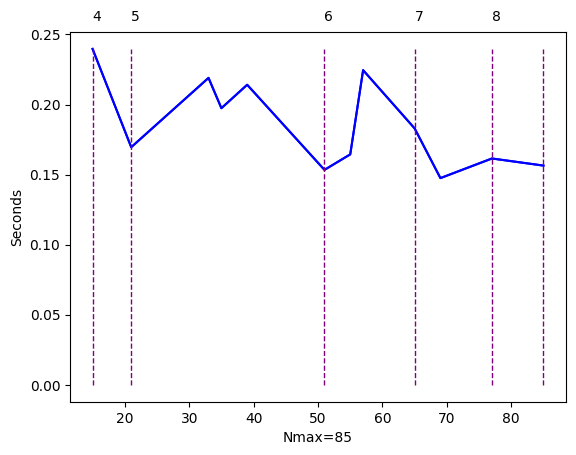

In [45]:
#Charts
plt.plot([15,21,33,35,39,51,55,57,65,69,77,85], timings, "b")
plt.ylabel("Seconds")
plt.xlabel("Nmax=85")

plt.plot([15,21,33,35,39,51,55,57,65,69,77,85], timings, "b")
plt.ylabel("Seconds")
plt.xlabel("Nmax=85")
plt.vlines(x=[15,21,51,65,77,85], ymin=0, ymax=max(timings), colors='purple', ls='--', lw=1, label='qubits')

for (x,y) in [(15,4),(21,5),(51,6),(65,7),(77,8)]:
    plt.text(x,max(timings)+0.02,y)